# Trayendo datos de poloniex y convirtiendolos en dataframe

In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData
%matplotlib inline

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2016-08-01 00:00:00"),
                  end=string2ts("2017-03-01 00:00:00"),
                  period=3600*4)

df2 = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-03-01 00:00:00"),
                  end=string2ts("2017-09-01 00:00:00"),
                  period=3600*4)

marketReturn = df["cum_r"][-1]*100
marketReturn2 = df2["cum_r"][-1]*100
print "Retorno final del mercado: %s"%(marketReturn)

df.info()

Retorno final del mercado: -51.9576719577
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1272 entries, 2016-08-01 03:00:00 to 2017-02-28 23:00:00
Data columns (total 11 columns):
close                 1272 non-null float64
high                  1272 non-null object
low                   1272 non-null float64
open                  1272 non-null float64
quoteVolume           1272 non-null object
volume                1272 non-null float64
weightedAverage       1272 non-null float64
retornos relativos    1272 non-null float64
log retornos          1272 non-null float64
cum_logr              1272 non-null float64
cum_r                 1272 non-null float64
dtypes: float64(9), object(2)
memory usage: 119.2+ KB


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

Retorno del mercacdo: -51.9576719577
Retorno de SMA13 VS EMA5: -18.9899380745
Retorno de Precio VS SMA20: -3.4436534531
Retorno de Precio VS EMA5: -12.6212234256


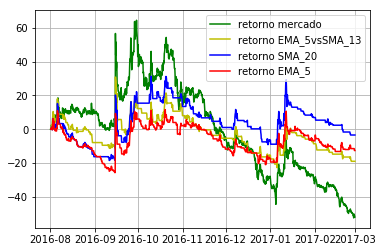

In [2]:
from strategy import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
relativeReturn,v = profit(w)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
relativeReturn3,v3 = profit(w3)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
relativeReturn2,v2 = profit(w2)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index,df['cum_r']*100,'g', label='retorno mercado')
plt.plot(df.index,v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index,v3*100,'b',label='retorno SMA_20')
plt.plot(df.index,v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()

## RSI via stockstacks

In [3]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock2 = StockDataFrame.retype(df2.copy())
stock["rsi_14"];
stock2["rsi_14"];

/home/daniel/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

In [4]:
#EMA_5vsSMA_13
w6 = EMAvsSMA(df2['weightedAverage'],13,5)
relativeReturn,v = profit(w6)

#Precio vs SMA_20
w7 = pricevsSMA(df2['weightedAverage'],20)
relativeReturn3,v3 = profit(w7)

#Precio vs EMA_5
# 23.6
w8 = pricevsEMA(df2['weightedAverage'])
relativeReturn2,v2 = profit(w8)

mldata.py:24: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/home/daniel/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/daniel/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


26459.8755944


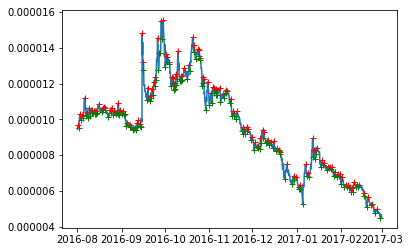

In [5]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"])

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print relReturn*100
data = pd.DataFrame(data={"price":df["close"],"volumen":df["volume"],"rsi":stock["rsi_14"] ,"sma20ema5":w["w"],"price_sma20":w3["w"],"price_ema5":w2["w"],"ideal_w":w4["w"]})
test_data = pd.DataFrame(data={"price":df2["close"],"volumen":df2["volume"],"rsi":stock2["rsi_14"],"price_sma20":w7["w"]})

# Creando modelo de regresion logistica utilizando sticklearn

In [6]:
from sklearn.linear_model import LogisticRegression

features = ["price","rsi","volumen"]


logreg = LogisticRegression()

logreg.fit(data[features][1:],data["ideal_w"][1:])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## probando modelo en otros datos

Retorno del mercacdo: 1074.17218543
Retorno de SMA13 VS EMA5: 1668.9673205
Retorno de Precio VS SMA20: 2520.48677891
Retorno de Precio VS EMA5: 4689.39387388
Retorno de ML_strategy: 170.452061564


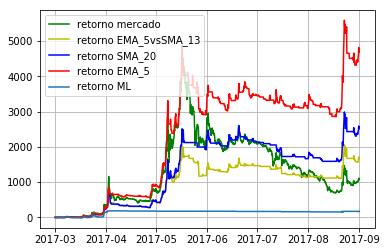

In [7]:
w_pred = logreg.predict(test_data[features][1:])

w5 = pd.DataFrame(data={"w":w_pred,"price":test_data["price"][1:]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

print 'Retorno del mercacdo: %s'%(marketReturn2)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)
print 'Retorno de ML_strategy: %s'%(relativeReturn5*100)

plt.plot(df2.index,df2['cum_r']*100,'g', label='retorno mercado')
plt.plot(df2.index,v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df2.index,v3*100,'b',label='retorno SMA_20')
plt.plot(df2.index,v2*100,'r',label='retorno EMA_5')
plt.plot(df2.index[1:],v5*100,label='retorno ML')

plt.legend(loc='best')
plt.grid()